# 1. IMPORT DATASETS AND LIBRARIES


In [ ]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras


In [ ]:
!pip install yfinance --upgrade --no-cache-dir -q

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime, timedelta

yf.pdr_override() # download data faster

start_date = '2010-01-01'
today_date = datetime.today().strftime('%Y-%m-%d')
print('Today\'s date: ', today_date)
tomorrow_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

# download dataframe
ticker = "AAPL"
raw_price_df = pdr.get_data_yahoo(ticker, start = start_date, end = tomorrow_date)

Today's date:  2023-08-21
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Sort the data based on Date
price_df_sorted = raw_price_df.sort_values(by = ['Date'])
price_df_sorted

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487534,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395379,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800
...,...,...,...,...,...,...
2023-08-14,177.970001,179.690002,177.309998,179.460007,179.460007,43675600
2023-08-15,178.880005,179.479996,177.050003,177.449997,177.449997,43622600
2023-08-16,177.130005,178.539993,176.500000,176.570007,176.570007,46964900


In [ ]:
price_df_sorted.shape

(3430, 6)

# 2. PERFORM EXPLORATORY DATA ANALYSIS AND VISUALIZATION

In [ ]:
# Check if Null values exist in stock prices data
price_df_sorted.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# Get stock prices dataframe info
price_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3430 entries, 2010-01-04 to 2023-08-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3430 non-null   float64
 1   High       3430 non-null   float64
 2   Low        3430 non-null   float64
 3   Close      3430 non-null   float64
 4   Adj Close  3430 non-null   float64
 5   Volume     3430 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 187.6 KB


In [ ]:
price_df_sorted.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3.430000e+03
mean,56.598753,57.220642,56.001845,56.635207,54.651376,2.472838e+08
std,52.295664,52.923263,51.716065,52.343763,52.737167,2.212266e+08
min,6.870357,7.000000,6.794643,6.858929,5.821836,3.145820e+07
25%,19.348750,19.553035,19.159375,19.357769,16.902870,9.595350e+07
50%,31.748750,31.930000,31.443749,31.691250,28.571409,1.581228e+08
75%,75.206877,76.093750,74.630625,75.769375,73.990751,3.348562e+08
max,196.240005,198.229996,195.279999,196.449997,196.185074,1.880998e+09


In [ ]:
# price_df_sorted.filter(['Close'])

In [ ]:
price_df = price_df_sorted.reset_index()[['Date', 'Close']]
price_df

,Date,Close
0,2010-01-04,7.643214
1,2010-01-05,7.656429
2,2010-01-06,7.534643
3,2010-01-07,7.520714
4,2010-01-08,7.570714
...,...,...
3425,2023-08-14,179.460007
3426,2023-08-15,177.449997
3427,2023-08-16,176.570007
3428,2023-08-17,174.000000


In [ ]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [ ]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(fig, df):
  for i in df.columns:
    if i != 'Date':
      fig.add_scatter(x = df['Date'], y = df[i], name = i)

In [ ]:
# plot interactive chart for stocks data
import plotly.graph_objs as go

# create initial figure object
original_price_fig = go.Figure()
original_price_fig.update_layout(title = f'{ticker}Stock Price History', xaxis_title = 'Date', yaxis_title = 'Close Price USD ($)')

# plot initial data
interactive_plot(original_price_fig, price_df)
original_price_fig.show()


# 3. PREPARE THE DATA BEFORE TRAINING THE AI/ML MODEL

### Convert the dataframe into array format

In [ ]:
# # filter dataframe based on date
# filtered_df = price_df.loc[price_df['Date'] >= '2021-05-28']
# filtered_df

In [ ]:
price_df

,Date,Close
0,2010-01-04,7.643214
1,2010-01-05,7.656429
2,2010-01-06,7.534643
3,2010-01-07,7.520714
4,2010-01-08,7.570714
...,...,...
3425,2023-08-14,179.460007
3426,2023-08-15,177.449997
3427,2023-08-16,176.570007
3428,2023-08-17,174.000000


In [ ]:
price_array = np.array(price_df['Close']).reshape(-1,1)
price_array.shape

(3430, 1)

### Splitting the dataset into the Training set and Test set

In [ ]:
# splitting dataset into train and test split this way, since order is important in time-series
# dont use train test split with it's default settings since it shuffles the data
def split_X_train_test(X, test_size=0.2):
  split = int((1-test_size) * len(X)) # round up the number
  X_train = X[:split]
  X_test = X[split:]

  return X_train, X_test

X_train_unscaled, X_test_unscaled = split_X_train_test(price_array, 0.01)

### Time steps

In [ ]:
time_steps = 60

### Add time steps for first X_test input

In [ ]:
X_train_len = X_train_unscaled.shape[0]

In [ ]:
X_train_unscaled.shape, X_test_unscaled.shape

((3395, 1), (35, 1))

In [ ]:
X_train_unscaled[-1], X_test_unscaled[0]

(array([189.58999634]), array([193.97000122]))

In [ ]:
X_test_unscaled = np.concatenate((X_train_unscaled[-time_steps:], X_test_unscaled), axis=0)

In [ ]:
X_test_unscaled.shape, X_test_unscaled[time_steps-1:time_steps+1]

((95, 1),
 array([[189.58999634],
        [193.97000122]]))

### Feature Scaling for NN


In [ ]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler (output = np.array format)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc.fit_transform(X_train_unscaled)
X_test_scaled = sc.transform(X_test_unscaled)

In [ ]:
X_train_scaled, X_train_scaled.shape

(array([[0.00429202],
        [0.00436434],
        [0.00369786],
        ...,
        [0.99162705],
        [0.99813936],
        [1.        ]]),
 (3395, 1))

In [ ]:
X_test_scaled, X_test_scaled.shape

(array([[0.86887839],
        [0.85864472],
        [0.86357004],
        [0.84917727],
        [0.84244609],
        [0.83861535],
        [0.86849527],
        [0.86657994],
        [0.86668933],
        [0.87347529],
        [0.87982344],
        [0.8744603 ],
        [0.86554015],
        [0.86723662],
        [0.8586995 ],
        [0.85864472],
        [0.884092  ],
        [0.89104204],
        [0.89054954],
        [0.88480337],
        [0.87883834],
        [0.86975393],
        [0.91233024],
        [0.91194712],
        [0.90247968],
        [0.91227546],
        [0.91331525],
        [0.90685772],
        [0.90412145],
        [0.90412145],
        [0.90751439],
        [0.92042955],
        [0.92103153],
        [0.91577787],
        [0.90133041],
        [0.90286271],
        [0.90915617],
        [0.92250905],
        [0.93274273],
        [0.93246908],
        [0.94801103],
        [0.9527174 ],
        [0.94522007],
        [0.94319527],
        [0.93558846],
        [0

### Creating the datasets with timesteps input

In [ ]:
import numpy as np

# convert an array of values into a dataset matrix
def create_dataset(array_data, time_steps=1):

  X, y = [], [] # become a list

  for i in range(time_steps, len(array_data)):
      X.append(array_data[i-time_steps:i, 0]) # its a 2D array => [row, col]
      y.append(array_data[i, 0])

  # return the new dataset
  return np.array(X), np.array(y) # convert into np array for RNN inputs

X_train, y_train = create_dataset(X_train_scaled, time_steps)
X_test, y_test = create_dataset(X_test_scaled, time_steps)

In [ ]:
X_train.shape, y_train.shape

((3335, 60), (3335,))

In [ ]:
X_test.shape, y_test.shape

((35, 60), (35,))

### Reshaping to 3D tensor for RNN input format

In [ ]:
  # RNN input params = (batch size, timesteps, features/indicators)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # add a new dimensionality to be compatible with the 3D tensor input shape of RNN and allow more indicators
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_train.shape, y_train.shape

((3335, 60, 1), (3335,))

In [ ]:
X_test.shape, y_test.shape

((35, 60, 1), (35,))

# 4. Building and Training the RNN

### load the model from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model(f'/content/drive/MyDrive/Projects/Stock Trend Prediction/models/{ticker}_model.h5')

In [ ]:

from keras.models import Sequential # allow us to build a NN object representing a sequence of layers
from keras.layers import Dense # add the output layer
from keras.layers import LSTM # add the LSTM layers
from keras.layers import Dropout # add dropout regularization

In [ ]:
# Create the model
model = Sequential() # regression -- predicting continuous values
model.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 150))
model.add(Dense(units = 1)) # dense class to create the fully-connected layer to fully connect the previous LSTM layer to one output unit

model.compile(optimizer='adam', loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 60, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 150)           180600    
                                                                 
 dropout_1 (Dropout)         (None, 60, 150)           0         
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 452,551
Trainable params: 452,551
Non-trai

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
file_path = f'/content/drive/MyDrive/Projects/Stock Trend Prediction/{ticker}_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[es, mc])

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.0017
Epoch 1: val_loss improved from inf to 0.00170, saving model to /content/drive/MyDrive/Projects/Stock Trend Prediction/AAPL_model.h5
42/42 [==============================] - 32s 604ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 2.4700e-04
Epoch 2: val_loss did not improve from 0.00170
42/42 [==============================] - 21s 495ms/step - loss: 2.4700e-04 - val_loss: 0.0019
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 2.4191e-04
Epoch 3: val_loss did not improve from 0.00170
42/42 [==============================] - 23s 546ms/step - loss: 2.4191e-04 - val_loss: 0.0020
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 2.4034e-04
Epoch 4: val_loss improved from 0.00170 to 0.00133, saving model to /content/drive/MyDrive/Projects/Stock Trend Prediction/AAPL_model.h5
42/42 [==============================] - 2

dict_keys(['loss', 'val_loss'])


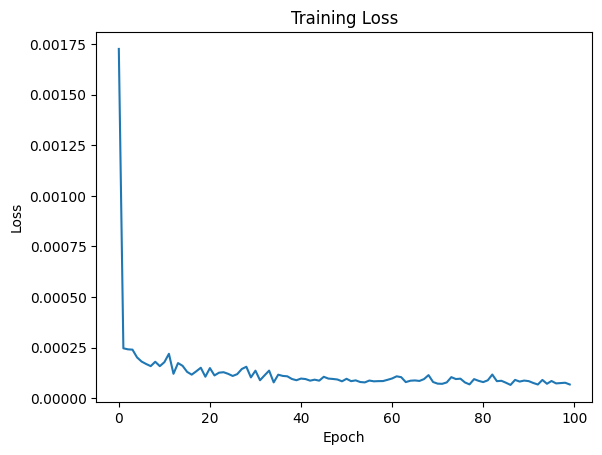

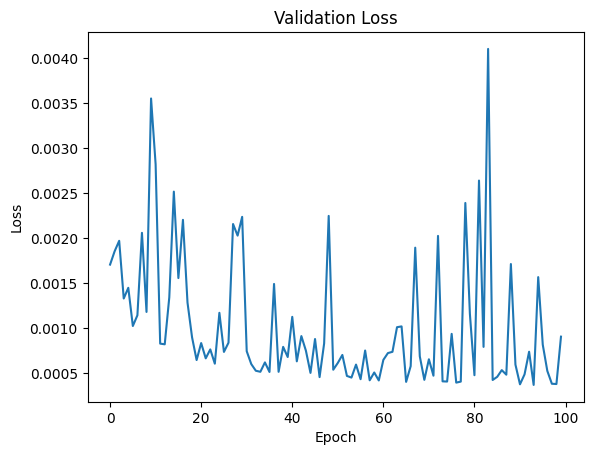

In [ ]:
print(history.history.keys())

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print('train accuracy: ', train_accuracy)
test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('test accuracy: ', test_accuracy)

105/105 [==============================] - 13s 121ms/step - loss: 2.1195e-04
train accuracy:  0.00021195053705014288
2/2 [==============================] - 0s 25ms/step - loss: 0.0026
test accuracy:  0.0026453242171555758


### Hyperparameter Tuning

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import itertools


# def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

#     first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
#     possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
#                                                   n_neurons, n_batch_size, dropout))

#     print(possible_combinations)
#     print('\n')

#     hist = []

#     for i in range(0, len(possible_combinations)):

#         print(f'{i+1}th combination: \n')
#         print('--------------------------------------------------------------------')

#         first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

#         # instantiating the model in the strategy scope creates the model on the TPU
#         #with tpu_strategy.scope():
#         regressor = Sequential()
#         regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#         regressor.add(Dropout(dropout))

#         if first_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         if second_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         if third_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         regressor.add(LSTM(units=n_neurons, return_sequences=False))
#         regressor.add(Dropout(dropout))
#         regressor.add(Dense(units=1, activation='linear'))
#         regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#         es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#         '''''
#         From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
#         alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
#         '''''

#         file_path = '/content/drive/MyDrive/Projects/Stock Trend Prediction/best_model.h5'

#         mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

#         '''''
#         cb = Callback(...)  # First, callbacks must be instantiated.
#         cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
#         model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
#         '''''

#         regressor.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

#         # load the best model
#         # regressor = load_model('best_model.h5')

#         train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
#         test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

#         hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
#                           train_accuracy, test_accuracy)))

#         print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')

#     return hist

In [ ]:
# config = [[False, True], [False, True], [False, True], [16, 32], [8, 16, 32], [0.2]]

# # list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

# hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

In [ ]:
# hist = pd.DataFrame(hist)
# hist = hist.sort_values(by=[7], ascending=True)
# hist

# 5. Plot the predictions

In [ ]:
# Make prediction
scaled_predictions = model.predict(X_test)

2/2 [==============================] - 1s 24ms/step


In [ ]:
predictions_array = sc.inverse_transform(scaled_predictions)
predictions_array.shape

(35, 1)

In [ ]:
y_test = sc.inverse_transform(y_test.reshape(-1,1))

In [ ]:
predictions_array.reshape(-1).shape, y_test.reshape(-1).shape

((35,), (35,))

In [ ]:
# Get the RMSE
rmse = np.sqrt(((predictions_array - y_test) ** 2).mean())
rmse

9.398352827772586

In [ ]:
# Append the predicted values to the list
predictions_list = []

for i in predictions_array:
  predictions_list.append(i[0])

len(predictions_list)

35

In [ ]:
train_df = price_df[:X_train_len]
train_df = train_df.rename(columns={'Close': 'Previous Prices'})

valid_df = price_df[X_train_len:]
valid_df = valid_df.rename(columns={'Close': 'Actual Closing Price'})
valid_df['Next Day Prediction'] = predictions_list

In [ ]:
valid_df

,Date,Actual Closing Price,Next Day Prediction
3395,2023-06-30,193.970001,179.382217
3396,2023-07-03,192.460007,181.336533
3397,2023-07-05,191.330002,182.193344
3398,2023-07-06,191.809998,181.775757
3399,2023-07-07,190.679993,181.246414
3400,2023-07-10,188.610001,180.540329
3401,2023-07-11,188.080002,179.398285
3402,2023-07-12,189.770004,178.503372
3403,2023-07-13,190.539993,178.809875
3404,2023-07-14,190.690002,179.769516


In [ ]:
train_df

,Date,Previous Prices
0,2010-01-04,7.643214
1,2010-01-05,7.656429
2,2010-01-06,7.534643
3,2010-01-07,7.520714
4,2010-01-08,7.570714
...,...,...
3390,2023-06-23,186.679993
3391,2023-06-26,185.270004
3392,2023-06-27,188.059998
3393,2023-06-28,189.250000


In [ ]:
# Plot the data
prediction_fig = go.Figure()
prediction_fig.update_layout(title = f"{ticker} Stock Trend Forecast", xaxis_title = 'Date', yaxis_title = 'Close Price USD ($)')

interactive_plot(prediction_fig, train_df)
interactive_plot(prediction_fig, valid_df)
prediction_fig.show()

# 6. Check Next day prediction

### Check date US stock market open day

In [ ]:
from datetime import datetime, timedelta

def get_previous_and_next_open_days(date_str):
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d').date()

    # Define a list of public holidays
    public_holidays = [
        datetime(2023, 1, 2),   # New Year's Day (observed)
        datetime(2023, 1, 16),  # Martin Luther King Jr. Day
        datetime(2023, 2, 20),  # Presidents' Day
        datetime(2023, 4, 14),  # Good Friday
        datetime(2023, 5, 29),  # Memorial Day
        datetime(2023, 7, 4),   # Independence Day (observed)
        datetime(2023, 9, 4),   # Labor Day
        datetime(2023, 11, 23), # Thanksgiving Day
        datetime(2023, 12, 25)  # Christmas Day
    ]

    previous_open_day = date
    next_open_day = date

    # Calculate the previous and next available stock market open days
    if date.weekday() in [5, 6] or date in public_holidays:
        while previous_open_day.weekday() in [5, 6] or previous_open_day in public_holidays:
            previous_open_day -= timedelta(days=1)

        while next_open_day.weekday() in [5, 6] or next_open_day in public_holidays:
            next_open_day += timedelta(days=1)

    elif date.weekday() == 4:
        previous_open_day -= timedelta(days=1)
        next_open_day += timedelta(days=3)

    elif date.weekday() == 0:
        previous_open_day -= timedelta(days=3)
        next_open_day += timedelta(days=1)

    else:
        previous_open_day -= timedelta(days=1)
        next_open_day += timedelta(days=1)

    # Return the previous and next available stock market open days as strings
    return previous_open_day.strftime('%Y-%m-%d'), next_open_day.strftime('%Y-%m-%d')

### Get a quote

In [ ]:
import math

# Get the latest data, predicting yesterday's price
start_date = (datetime.today() - timedelta(days=(time_steps + math.ceil(time_steps/30 * 20 )))).strftime('%Y-%m-%d')
today_date = datetime.today().today().strftime('%Y-%m-%d')
prev_date, next_date = get_previous_and_next_open_days(today_date)
latest_df = pdr.get_data_yahoo(ticker, start = start_date, end = prev_date)
print('Dataset\'s Start date: ', start_date)
print('Today: ', today_date)
print('Yesterday: ', prev_date)
print('Tomorrow: ', next_date)
# print(latest_df.shape)

# Create a new dataframe
time_steps_df_sorted = latest_df.sort_values(by = ['Date'])
time_steps_df = time_steps_df_sorted.reset_index()[['Close']]
# Get the last 150 days closing price values and convert the dataframe to an array
time_steps_array = np.array(time_steps_df['Close'][-time_steps:]).reshape(-1,1)
# print(time_steps_array.shape)
# Normalization
X_test_quote = sc.transform(time_steps_array)
# Reshape the data
X_test_quote = np.reshape(X_test_quote, (1, X_test_quote.shape[0], X_test_quote.shape[1]))
# Get the predicted price
pred_quote = model.predict(X_test_quote)
# Unscaled
pred_quote = sc.inverse_transform(pred_quote)

print(f'{prev_date} predicted price: ', pred_quote[0][0])

[*********************100%%**********************]  1 of 1 completed
Dataset's Start date:  2023-05-13
Today:  2023-08-21
Yesterday:  2023-08-18
Tomorrow:  2023-08-22
1/1 [==============================] - 0s 33ms/step
2023-08-18 predicted price:  169.86678


In [ ]:
quote = pdr.get_data_yahoo(ticker, start = prev_date, end = today_date)
quote['Close']

[*********************100%%**********************]  1 of 1 completed


Date
2023-08-18    174.490005
Name: Close, dtype: float64

# 7. Forecast Trend for the next 10 days

In [ ]:
import pandas as pd
import numpy as np


# No. of days for price prediction
pred_days = 100

input_df = price_df.iloc[:X_train_len]
input_df = input_df.iloc[-time_steps:]
date = (input_df.iloc[-1]['Date']).strftime('%Y-%m-%d')
print('Previous Open Day: ', date, '\n')
print(input_df,'\n')
input_array = np.array(input_df['Close']).reshape(-1,1)

output_df = pd.DataFrame({'Date': [], 'Actual Closing Price': [], f'Next {pred_days} days Forecast': []})

# Normalization
input_array = sc.transform(input_array)
# print(type(input_array), input_array.shape)


date_array = pd.to_datetime(price_df['Date'].values).strftime('%Y-%m-%d').values
# Loop over the prediction period and add new rows to the input data for each day
for i in range(pred_days):
  X_input = input_array[-time_steps:]

  # Reshape the data
  X_input_3D = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

  # Get the scaled predicted price
  output_scaled = model.predict(X_input_3D)

  # add new row to existing input data for prediction
  # print(f"input_array shape: {input_array.shape}, output_scaled shape: {output_scaled.shape}")
  input_array = np.vstack((input_array, output_scaled))

  # Unscaled
  output = sc.inverse_transform(output_scaled)

  # get tmr date
  _, date = get_previous_and_next_open_days(date)
  print(f'Predicted price on {date}: {output[0][0]}')

  # Get closing price on specific date
  if date in date_array:
    # If the search date exists, get its corresponding 'close' column data
    close_data = price_df.loc[price_df['Date'] == date, 'Close'].values[0]
  else:
    close_data = np.nan

  # Create a new row for the current day
  new_row = {'Date': date, 'Actual Closing Price': close_data, f'Next {pred_days} days Forecast': output[0][0]}

  # Append the new row to the input data DataFrame
  output_df = pd.concat([output_df, pd.DataFrame([new_row])], ignore_index=True)

print(output_df)
print(price_df.iloc[X_train_len:])

Previous Open Day:  2023-06-29 

           Date       Close
3335 2023-04-04  165.630005
3336 2023-04-05  163.759995
3337 2023-04-06  164.660004
3338 2023-04-10  162.029999
3339 2023-04-11  160.800003
3340 2023-04-12  160.100006
3341 2023-04-13  165.559998
3342 2023-04-14  165.210007
3343 2023-04-17  165.229996
3344 2023-04-18  166.470001
3345 2023-04-19  167.630005
3346 2023-04-20  166.649994
3347 2023-04-21  165.020004
3348 2023-04-24  165.330002
3349 2023-04-25  163.770004
3350 2023-04-26  163.759995
3351 2023-04-27  168.410004
3352 2023-04-28  169.679993
3353 2023-05-01  169.589996
3354 2023-05-02  168.539993
3355 2023-05-03  167.449997
3356 2023-05-04  165.789993
3357 2023-05-05  173.570007
3358 2023-05-08  173.500000
3359 2023-05-09  171.770004
3360 2023-05-10  173.559998
3361 2023-05-11  173.750000
3362 2023-05-12  172.570007
3363 2023-05-15  172.070007
3364 2023-05-16  172.070007
3365 2023-05-17  172.690002
3366 2023-05-18  175.050003
3367 2023-05-19  175.160004
3368 2023-05-22

### Check RMSE for the test data

In [ ]:
rmse_forecast_df = output_df.dropna()
print(rmse_forecast_df)

rmse_pred_trend = np.sqrt(((rmse_forecast_df['Actual Closing Price'].values - rmse_forecast_df[f'Next {pred_days} days Forecast'].values) ** 2).mean())
print(f'RMSE for the above days: ', rmse_pred_trend)

          Date  Actual Closing Price  Next 100 days Forecast
0   2023-06-30            193.970001              179.382217
1   2023-07-03            192.460007              176.010223
3   2023-07-05            191.330002              167.066635
4   2023-07-06            191.809998              163.303635
5   2023-07-07            190.679993              160.284454
6   2023-07-10            188.610001              157.937241
7   2023-07-11            188.080002              156.120224
8   2023-07-12            189.770004              154.680771
9   2023-07-13            190.539993              153.489151
10  2023-07-14            190.690002              152.453110
11  2023-07-17            193.990005              151.518204
12  2023-07-18            193.729996              150.659744
13  2023-07-19            195.100006              149.871201
14  2023-07-20            193.130005              149.153458
15  2023-07-21            191.940002              148.506973
16  2023-07-24          

In [ ]:
pred_output_df = output_df.drop('Actual Closing Price', axis = 1)
interactive_plot(prediction_fig, pred_output_df)
prediction_fig.show()